## Time-variant channel test

In [355]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import random
%matplotlib inline

In [356]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [357]:
#Paramètres du scenario 4
#Bernoulli Parameters
p0 = np.array([1., .6, .4, .25, .18, .1, .06, .04]) #0
p1 = np.array([.8, .6, .4, .25, .18, .1, .06, .04]) #1
p2 = np.array([.95, .90, .95, .55, .4, .25, .15, .10]) #2
p3 = np.array([.95, .90, .80, .65, .45, .25, .15, .10]) #3
p4 = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #4
p5 = np.array([.90, .80, .70, .55, .45, .35, .20, .10]) #5
p6 = np.array([.90, .80, .70, .55, .50, .38, .30, .20]) #6
p7 = np.array([.90, .80, .70, .55, .50, .38, .30, .25]) #7
p = np.array([p0, p1, p2, p3, p4, p5, p6, p7])

rate = np.array([6, 9, 12, 18, 24, 36, 48, 64])

tp0 = np.multiply(p0,rate)
tp1 = np.multiply(p1,rate)
tp2 = np.multiply(p2,rate)
tp3 = np.multiply(p3,rate)
tp4 = np.multiply(p4,rate)
tp5 = np.multiply(p5,rate)
tp6 = np.multiply(p6,rate)
tp7 = np.multiply(p7,rate)
tp = np.array([tp1, tp2, tp3, tp4, tp5, tp6, tp7])

K= p0.shape[0] #Number of branches

delta0 = ( np.ones(K)*np.max(tp0) ) - tp0
delta1 = ( np.ones(K)*np.max(tp1) ) - tp1
delta2 = ( np.ones(K)*np.max(tp2) ) - tp2
delta3 = ( np.ones(K)*np.max(tp3) ) - tp3
delta4 = ( np.ones(K)*np.max(tp4) ) - tp4
delta5 = ( np.ones(K)*np.max(tp5) ) - tp5
delta6 = ( np.ones(K)*np.max(tp6) ) - tp6
delta7 = ( np.ones(K)*np.max(tp7) ) - tp7
delta = np.array([delta0, delta1, delta2, delta3, delta4, delta5, delta6, delta7])

T= 10000 #Time periods
runs = 10 #Number of iterations
print("Pi:",tp0)
print("Pi:",tp1)
print("Pi:",tp2)
print("Pi:",tp3)
print("Pi:",tp4)
print("Pi:",tp5)
print("Pi:",tp6)
print("Pi:",tp7)
# print("delta:",delta)


Pi: [6.   5.4  4.8  4.5  4.32 3.6  2.88 2.56]
Pi: [4.8  5.4  4.8  4.5  4.32 3.6  2.88 2.56]
Pi: [ 5.7  8.1 11.4  9.9  9.6  9.   7.2  6.4]
Pi: [ 5.7  8.1  9.6 11.7 10.8  9.   7.2  6.4]
Pi: [ 5.94  8.82 11.52 16.74 21.6   3.6   2.88  2.56]
Pi: [ 5.4  7.2  8.4  9.9 10.8 12.6  9.6  6.4]
Pi: [ 5.4   7.2   8.4   9.9  12.   13.68 14.4  12.8 ]
Pi: [ 5.4   7.2   8.4   9.9  12.   13.68 14.4  16.  ]


## KL-UCB

In [358]:
%%capture
sw = kl_ucb_policy.GORS_SW(K, rate, 1000) #Optimal Graphical OptimalRate Sampling
total_rewards_list_gors = np.zeros((runs, T))
actions_list_gors = []
klucb = kl_ucb_policy.KLUCBPolicy(K, rate) #Original KL UCB
total_rewards_list_klucb = np.zeros((runs, T))
actions_list_klucb = []
start_time = time.time()

total_regret_sw  = np.zeros((runs,T), dtype=float)
total_regret_klucb = np.zeros((runs,T), dtype=float)

for run in range(runs):
    sw.reset()
    actions_gors = np.zeros((K, T), dtype=np.int)
    rewards_gors = np.zeros((K, T), dtype=np.float)
    klucb.reset()
    actions_klucb = np.zeros((K, T), dtype=np.int)
    rewards_klucb = np.zeros((K, T), dtype=np.float)
    index = 0
    p_index = 0
    for t in range(T):
        # print('at time slot: ',t)
        if index == T//8:
            p_index += 1
            index = 0
            print(p_index)
        else:
            index += 1
        arm_gors = sw.select_next_arm()
        actions_gors[arm_gors, t] = 1
        rewards_gors[arm_gors, t] = np.random.binomial(1, p[p_index][arm_gors]) * rate[arm_gors]
        sw.update_state(arm_gors, rewards_gors[arm_gors, t] / rate[arm_gors])
        total_regret_sw[run, t] = total_regret_sw[run, t-1] + np.dot(delta[p_index],actions_gors[:,t])

        arm_klucb = klucb.select_next_arm()
        actions_klucb[arm_klucb, t] = 1
        rewards_klucb[arm_klucb, t] = np.random.binomial(1, p[p_index][arm_klucb]) * rate[arm_klucb]
        klucb.update_state(arm_klucb, rewards_klucb[arm_klucb, t] / rate[arm_klucb])
        total_regret_klucb[run, t] = total_regret_klucb[run, t-1] + np.dot(delta[p_index],actions_klucb[:,t])

    cumulative_rewards_gors = np.cumsum(rewards_gors, axis=1) #Cumulative rewards of each arm according to time
    total_rewards_gors = np.sum(cumulative_rewards_gors, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_gors[run, :] = np.copy(total_rewards_gors)
    actions_list_gors.append(np.copy(actions_gors))

    cumulative_rewards_klucb = np.cumsum(rewards_klucb, axis=1)
    total_rewards_klucb = np.sum(cumulative_rewards_klucb, axis=0)
    total_rewards_list_klucb[run, :] = np.copy(total_rewards_klucb)
    actions_list_klucb.append(np.copy(actions_klucb))

time_spent = time.time() - start_time

In [359]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent), "seconds")

Time for KL-UCB (Newton), with T = 10000 , runs = 10 : 29.880515575408936 seconds


## Résultats

## Gain total moyen

In [360]:
mean_total_rewards_gors = np.mean(total_rewards_list_gors, axis=0)
mean_total_rewards_klucb = np.mean(total_rewards_list_klucb, axis=0)
print("t & Reward (total) G-ORS :", t, mean_total_rewards_gors[t])
print("t & Reward (total) KL-UCB :", t, mean_total_rewards_klucb[t])

t & Reward (total) G-ORS : 9999 78112.4
t & Reward (total) KL-UCB : 9999 79461.0


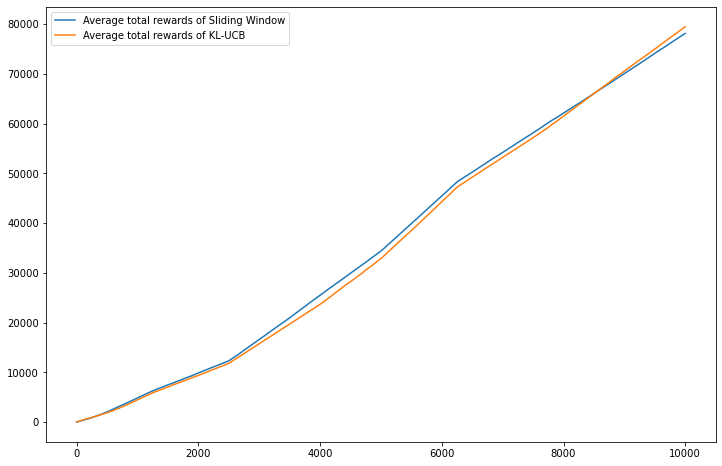

In [361]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(mean_total_rewards_gors, linestyle='-', label='Average total rewards of Sliding Window')
ax1.plot(mean_total_rewards_klucb, linestyle='-', label='Average total rewards of KL-UCB')
ax1.legend(loc='best')
plt.show()

In [362]:
#Regrets calculation for G-ORS
regret_cumule_gors = np.mean(total_regret_sw, axis=0) # Cumulative regrets

#Regrest calculation for KL-UCB
regret_cumule_klucb = np.mean(total_regret_klucb, axis=0) # Cumulative regrets

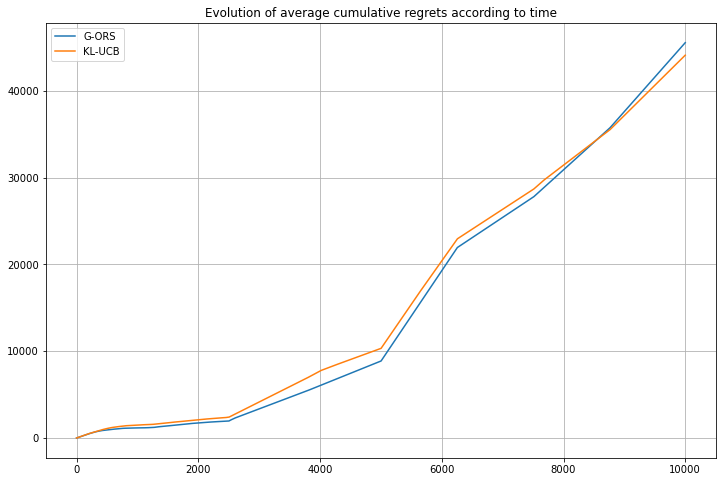

In [363]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_gors[:],linestyle='-', label='G-ORS')
ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
#ax1.xscale('log')
plt.show()

## Distribution du regret

In [364]:
T0 = 4999

In [365]:
#G-ORS
distribution_regret_gors = np.sum(total_regret_sw, axis=1)
distribution_regret_klucb = np.sum(total_regret_klucb, axis=1)
# for actions_gors in actions_list_gors:
#     distribution_regret_gors.append(np.dot(delta, np.sum(actions_gors[:, :T0], axis=1)))
# for actions_klucb in actions_list_klucb:
#     distribution_regret_klucb.append(np.dot(delta, np.sum(actions_klucb[:, :T0], axis=1)))

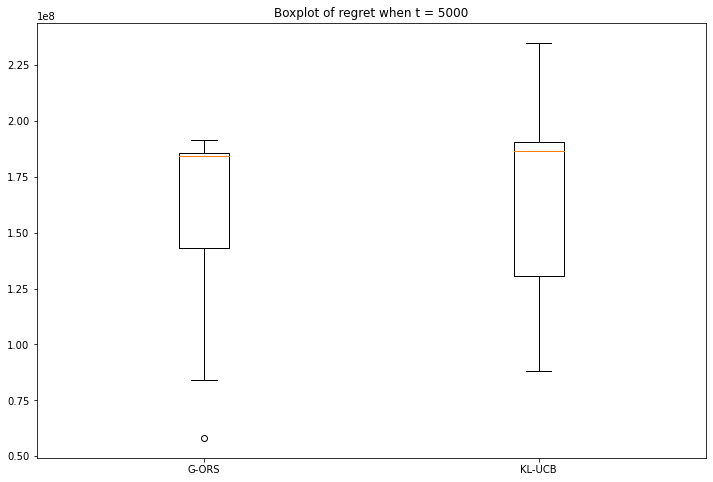

In [366]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_gors,
        distribution_regret_klucb
    ])
ax.set_xticklabels([
        'G-ORS',
        'KL-UCB'
    ])

ax.set_title('Boxplot of regret when t = 5000')
plt.show()